**Poisson equation in 1D with Dirichlet/PointSetOperator boundary conditions**

Retyped by Theodoret Putra Agatho on 7 Aug. 2023

[Source](https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/poisson.1d.pointsetoperator.html)

In [1]:
pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.3/165.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 6.0 MB/s eta 0:00:00


**Problem setup**

We will solve a Possion equation

\begin{align}
        \Delta u = 2, x \in [-1, 1].
    \end{align}

with the Neumann boundary conditions on the right boundary

\begin{align}
        \left. \frac{\partial u}{\partial x} \right|_{x=1} = 4
    \end{align}

and Dirichlet boundary conditions on the left boundary

\begin{align}
        u(-1) = 0.
    \end{align}

The exact solution is $u(x) = (x + 1)^2$.

**Implementation**

This description goes through the implementation of a solver for the above described Poisson equation step-by-step. First, the DeepXDE and TensorFlow(`tf`) modules are imported:

In [2]:
import deepxde as dde
from deepxde.backend import tf

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


We begin by defining a computational geometry. We can use a built-in class `Interval` as follows

In [3]:
geom = dde.geometry.Interval(-1, 1)

Next, we express the PDE residual of the Possion equation:

In [4]:
def pde(x, y):
  dy_xx = dde.grad.hessian(y, x)
  return dy_xx - 2

The first argument to `pde` is the network input, i.e., the $x$-coordinate. The second argument is the network output, i.e., the solution $u(x)$, but here we use `y` as the name of the variable.

Next, we consider the Neumann boundary condition and Dirichlet boundary condition respectively.

The Dirichlet boundary condition is defined by a simple Python function. The function should return `True` for those points satisfying $x = 0$ and `False` otherwise (Note that because of rounding-off errors, it is often wise to use `dde.utils.isclose` to test whether two floating point values are equivalent). In this function, the argument `x` to `boundary` is the network input and is a $d$-dim vector, where $d$ is the dimension and $d = 1$ in this case. Then a boolean `on_boundary` is used as the second argument. If the point `x` (the first argument) is on the boundary of the geometry, in this case Dirichlet boundary when it reaches the left endpoint of the interval, then `on_boundary` is `True`, otherwise, `on_boundary` is `False`.

In [5]:
def boundary_l(x, on_boundary):
  return on_boundary and dde.utils.isclose(x[0], -1)

Next, we define a function to return the value of $u(x)$ for the points $x$ on the Dirichlet boundary. In this case, it is $u(x) = 0$. For example, $(x + 1)^2$ is 0 on the boundary, and thus we can also use

In [6]:
def func(x):
  return (x + 1) ** 2

Then, the Dirichlet boundary condition is

In [7]:
bc_l = dde.icbc.DirichletBC(geom, func, boundary_l)

For Neumann boundary condition, rather than using *NeumannBC()*, we use *PointSetOperatorBC()* which needs the following inputs -> points on the Neumann boundary, actual solution for Neumann BC and the function for predicted Neumann BC. We start with the actual solution for Neumann BC. Since the actual solution $u = (x + 1)^2$ is known, we can define a function to calculate the actual Neumann BC (it is the first derivative) as:

In [8]:
def d_func(x):
  return 2 * (x + 1)

Next, we define a function to calculate the predicted Neumann BC

In [9]:
def dy_x(x, y, X):
  dy_x = dde.grad.jacobian(y, x)
  return dy_x

Finally we define *PointSetOperatorBC()* on the points that lie on the right boundary in a similar way as Dirichlet BC.

In [11]:
boundary_pts = geom.random_boundary_points(2)
r_boundary_pts = boundary_pts[dde.utils.isclose(boundary_pts, 1)].reshape(-1, 1)
bc_r = dde.icbc.PointSetOperatorBC(r_boundary_pts, d_func(r_boundary_pts), dy_x)

Now, we have specified the geometry, PDE residual, Dirichlet boundary condition and Neumann boundary condition. We then define the PDE problem as

In [12]:
data = dde.data.PDE(geom, pde, [bc_l, bc_r], 16, 2, solution=func, num_test=100)

The number 16 is the number of training residual points sampled inside the domain, and the number 2 is the number of training points sampled on the boundary. The argument `solution=func` is the reference solution to compute the error of our solution, and can be ignored if we don't have a reference solution. We use 100 residual points for testing the PDE residual.

Next, we choose the network. Here, we use a fully connected neural network of depth 4 (i.e., 3 hidden layers) and width 50:

In [13]:
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

Now, we have the PDE problem and the network. We build a `Model`.

In [14]:
model = dde.Model(data, net)

To evaluate the intermediate values for any given function during training, we can use *OperatorPredictor*. Let's say we would like to write the first and second derivatives on the boundary points into two different files. To achieve that, we first define the functions for first and second derivatives

In [15]:
def dy_x(x, y):
  dy_x = dde.grad.jacobian(y, x)
  return dy_x

def dy_xx(x, y):
  dy_xx = dde.grad.hessian(y, x)
  return dy_xx

Then we define the *OperatorPredictor* callbacks:

In [17]:
first_derivative = dde.callbacks.OperatorPredictor(
    geom.random_boundary_points(2), op=dy_x, period=200, filename="first_derivative.txt"
)

second_derivative = dde.callbacks.OperatorPredictor(
    geom.random_boundary_points(2),
    op=dy_xx,
    period=200,
    filename="second_derivative.txt",
)

For optimization, we set the optimizer and learning rate. We also compute the $L^2$ relative error as a metric during training. We then train the model for 10000 iterations:

In [18]:
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(
    iterations=10000, callbacks=[first_derivative, second_derivative]
)

Compiling model...
Building feed-forward neural network...
'build' took 0.080607 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.592770 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [4.17e+00, 5.16e-01, 2.08e+01]    [4.08e+00, 5.16e-01, 2.08e+01]    [1.17e+00]    
1000      [5.96e-04, 7.66e-08, 1.20e-06]    [3.84e-04, 7.66e-08, 1.20e-06]    [8.85e-04]    
2000      [8.28e-05, 1.66e-09, 3.15e-08]    [7.27e-05, 1.66e-09, 3.15e-08]    [4.28e-04]    
3000      [3.06e-05, 4.17e-11, 3.44e-09]    [3.08e-05, 4.17e-11, 3.44e-09]    [4.79e-04]    
4000      [1.10e-05, 4.74e-10, 2.90e-09]    [1.24e-05, 4.74e-10, 2.90e-09]    [3.60e-04]    
5000      [6.34e-06, 1.21e-09, 6.27e-10]    [8.18e-06, 1.21e-09, 6.27e-10]    [2.81e-04]    
6000      [8.24e-06, 4.93e-06, 1.30e-05]    [1.09e-05, 4.93e-06, 1.30e-05]    [9.78e-04]    
7000      [2.44e-05, 4.31e-05, 8.40e-05]    [2.60e-05, 4.31e-05, 8.40e-05]    [2.44e-03]    
8000      [3.71e-06, 7.04e-09, 2.91e-08]    [5.54e-06, 7.04e-09, 2.91e-08]    [2.57e-04]    
9000      [3.10e-06, 8.3

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


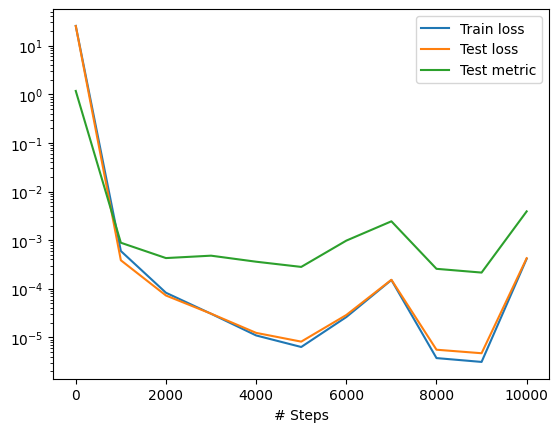

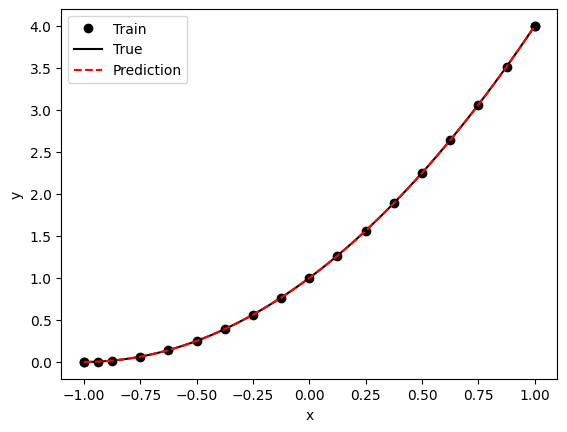

In [19]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)